In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re
import seaborn as sns
from tqdm import tqdm
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize,sent_tokenize
#from fuzzywuzzy import fuzz

train_example_paths = glob.glob('data/train/*.json')
test_example_paths = glob.glob('data/test/*.json')

train_example_names = [fn.split('.')[0] for fn in os.listdir('data/train')]
test_example_names = [fn.split('.')[0] for fn in os.listdir('data/test')]

metadata = pd.read_csv('data/train.csv')
metadata_train = metadata.loc[metadata.Id.isin(train_example_names)]
metadata_test = metadata.loc[metadata.Id.isin(test_example_names)]

metadata = pd.read_csv('data/train.csv')
metadata_train = metadata.loc[metadata.Id.isin(train_example_names)]
metadata_test = metadata.loc[metadata.Id.isin(test_example_names)]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ozano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

def remove_punc(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt))

def get_doc_id(doc_path):
    return os.path.split(train_example_names[0])[-1].split('.')[0]

def load_train_example(i: int):
    doc_path = train_example_paths[i]
    with open(doc_path) as f:
        data = json.load(f)
    return {'doc': data, 'meta': metadata.loc[metadata.Id == get_doc_id(doc_path)]}

def load_train_example_by_name(name):
    doc_path = os.path.join('data/train', name + '.json')
    with open(doc_path) as f:
        data = json.load(f)
    return data

def delete_file(filename):
    if os.path.exists(filename):
        os.remove(filename)

## Split Data

In [3]:
import random

docIdx = train_example_names.copy()
"""random.seed(42)
random.shuffle(docIdx)

train_ratio = 0.85
n_train = int(len(docIdx) * train_ratio)
n_val = len(docIdx) - n_train

train_idx = docIdx[:n_train]
val_idx = docIdx[n_train:]"""

"""print(f'train size: {len(train_idx)}')
print(f'val size: {len(val_idx)}')"""

"print(f'train size: {len(train_idx)}')\nprint(f'val size: {len(val_idx)}')"

## Generate Dataset and Features

In [4]:
RE_COMBINE_WHITESPACE = re.compile(r"\s+")

def preprocess_tokenize_doc(doc_json):
    #doc_text = ' '.join([remove_punc(sec['text']) for sec in doc_json])
    doc_text = make_single_whitespace(doc_text)
    
    doc_tokens = doc_text
    return doc_tokens

def indices(lst, element):
    e = element.lower()
    result = [i for i, token in enumerate(lst) if e in token.lower()]
    return result

def make_single_whitespace(text):
    return RE_COMBINE_WHITESPACE.sub(" ", text).strip()

## Create dataframe for tokens and targets

In [5]:
# Basic text cleaning

# Note that I removed lower from the original code here
def text_cleaning(text):
    text = re.sub("\s+"," ", text) # remove extra spaces
    text = ''.join([k for k in text if k not in string.punctuation]) # remove punctuation
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text)).strip() # remove unnecessary literals and Perform Case Normalization
    return text

re_find_par = re.compile(r'\(([A-Z]{2,}-?[A-Z]{1,}?[a-z]?)[\);]')



def text_preprocess(text):
    #text = text.replace('(', 'specialparstart').replace(')', 'specialparend')
    text = re.sub(r'\[[0-9]+]', 'specialreference', text)
    # Remove dates
    text = re.sub(r'(19|20)[0-9][0-9]', 'specialyear', text)
    
    return text



In [6]:
import string

##### STEP 1: Make a list of the known labels provided to us

temp_1 = [text_cleaning(x) for x in metadata['dataset_label']]
temp_2 = [text_cleaning(x) for x in metadata['dataset_title']]
temp_3 = [text_cleaning(x) for x in metadata['cleaned_label']]

existing_labels = temp_1 + temp_2 + temp_3
existing_labels = [l.lower() for l in existing_labels]
existing_labels = set(existing_labels)


val_labels = [
    'rsna international covid 19 open radiology database',
    'rsna international covid 19 open radiology database ricord',
    'rsna international covid open radiology database',
    'rsna international covid19 open radiology database',
    'rsna international covid19 open radiology database ricord',
    'noaa c cap',
    'noaa ccap',
    'noaa international best track archive for climate stewardship',
    'noaa national water level observation network',
    'noaa optimum interpolation sea surface temperature',
    'noaa sea lake and overland surges from hurricanes',
    'noaa storm surge inundation',
    'noaa tidal station',
    'noaa tide gauge',
    'noaa tide station',
    'noaa water level station',
    'noaa world ocean database'
]

existing_labels = [l for l in existing_labels if l not in val_labels]

In [7]:
count_BIO = 0
count_O = 0

val_idx = []
train_idx = []

def has_abbreviation(doc_text):
    return len(re_find_par.findall(doc_text)) > 0

def get_doc(doc_id):
    global count_BIO
    global count_O

    doc_json = load_train_example_by_name(doc_id)
    doc_text = ' '.join([sec['text'] for sec in doc_json])

    #count_BIO = 0
    #count_O = 0
    X = []
    y = []

    # Tokenize sentencewise
    sentences = sent_tokenize(doc_text)
    ##### STEP 2: For each sentence in our dataset
    has_val_lab = False
    
    for sentence in sentences:
        lab_len = 0
        max_lab = ""
        sentence = text_preprocess(sentence)
        
        # Remove sentences without (ABBR.)
        """if not has_abbreviation(sentence):
            continue

        if 'specialreference' in sentence:
            continue"""

        clean_sent_upper = text_cleaning(sentence) # Still uppercase
        clean_sent_lower = clean_sent_upper.lower()
        tokenized_sent_upper = word_tokenize(clean_sent_upper)
        tokenized_sent_lower = word_tokenize(clean_sent_lower)

        assert len(tokenized_sent_upper) == len(tokenized_sent_lower), 'Lowercase and uppercase tokens must have the same count.'

        bio_labels = []
        
        ##### STEP 2 i): Out of all matching labels in the sentence, find the label with maximum length

        has_train_lab = False
        for clean_lab in existing_labels:
            if clean_lab in clean_sent_lower and lab_len < len(clean_lab):
                lab_len = len(clean_lab)
                max_lab = clean_lab
                has_train_lab = True

        if not has_train_lab:
            for clean_lab in val_labels:
                if clean_lab in clean_sent_lower and lab_len < len(clean_lab):
                    lab_len = len(clean_lab)
                    max_lab = clean_lab
                    has_val_lab = True
        
        ##### STEP 2 ii): Use the selected label of maximum length to annotate the sentence using BIO tokens
        if lab_len > 0:
            tokenized_lab = word_tokenize(max_lab)
            en = 0
            for word_lower in tokenized_sent_lower:
                if en < len(tokenized_lab) and word_lower == tokenized_lab[en]:
                    if en == 0:
                        bio_labels.append('B')
                    else:
                        bio_labels.append('I')
                    en += 1
                else:
                    bio_labels.append('O')

            count_BIO += 1
            
        ##### STEP 2 iii): If no label was found then annotate the sentence using only O token
        else:
            count_O += 1

            # Drop some negative sentences to save memory (90%)
            if random.uniform(0, 1) < 0.1:
                for word in tokenized_sent_upper:
                    bio_labels.append('O')
            else:
                continue
        
        y.append(bio_labels)
        X.append(tokenized_sent_upper)
    
    if has_val_lab:
        val_idx.append(doc_id)
    else:
        train_idx.append(doc_id)

    return X, y # Both list of lists

#get_doc(docIdx[0])[0]

## Create Dataset for All Documents

In [11]:
doc_data_x = {}
doc_data_y = {}

for doc_id in tqdm(docIdx):
    doc_X, doc_y = get_doc(doc_id)
    doc_data_x[doc_id] = doc_X
    doc_data_y[doc_id] = doc_y

100%|██████████| 14316/14316 [21:43<00:00, 10.99it/s]


In [12]:
print(f'count_BIO: {count_BIO}')
print(f'count_O: {count_O}')

count_BIO: 55891
count_O: 4123030


In [13]:
import pickle

##### STEP 3: Pickle the resulting dataset
"""with open('data//doc_data_x.pkl', 'wb') as f:
    pickle.dump(doc_data_x, f)
"""

with open('data//doc_data_y.pkl', 'wb') as f:
    pickle.dump(doc_data_y, f)

for doc_id in docIdx:
    with open(f'data/crf_x_data/{doc_id}.pkl', 'wb') as f:
        pickle.dump(doc_data_x[doc_id], f)

for doc_id in docIdx:
    with open(f'data/crf_y_data/{doc_id}.pkl', 'wb') as f:
        pickle.dump(doc_data_y[doc_id], f)

In [14]:
print(f'train size: {len(train_idx)}')
print(f'val size: {len(val_idx)}')

train size: 13888
val size: 428


In [15]:
with open(f'data/train_idx.pkl', 'wb') as f:
        pickle.dump(train_idx, f)

with open(f'data/val_idx.pkl', 'wb') as f:
        pickle.dump(val_idx, f)

## Load Dataset

In [8]:
import pickle

"""with open('data//doc_data_x.pkl', 'rb') as f:
    doc_data_x = pickle.load(f)"""

with open('data//doc_data_y.pkl', 'rb') as f:
    doc_data_y = pickle.load(f)

with open(f'data/train_idx.pkl', 'rb') as f:
    train_idx = pickle.load(f)

with open(f'data/val_idx.pkl', 'rb') as f:
    val_idx = pickle.load(f)

In [9]:
import crf_feature_extractor

feature_extractor = crf_feature_extractor.TextFeatureExtractor()

## Create Generators

In [10]:
import random

def X_generator(doc_idx):
    for doc_id in doc_idx:
        with open(f'data/crf_x_data/{doc_id}.pkl', 'rb') as f:
            doc_X = pickle.load(f)

        for sent_tokens in doc_X:
            doc_df = pd.DataFrame({'TOKEN': sent_tokens})

            features = feature_extractor.transform({'output': doc_df})['output'][0]
            del doc_df
            yield features

def y_generator(doc_idx):
    for doc_id in doc_idx:
        doc_y = doc_data_y[doc_id]

        for sent_targets in doc_y:
            yield sent_targets

def get_X_train_generator():
    return X_generator(train_idx)
    
def get_X_val_generator():
    return X_generator(val_idx)

def get_y_train_generator():
    return y_generator(train_idx)
    
def get_y_val_generator():
    return y_generator(val_idx)

In [11]:
data = {}
data['train_data'] = (get_X_train_generator, get_y_train_generator)
data['val_data'] = (get_X_val_generator, get_y_val_generator)

## Create CRF Model

In [12]:
from mlmodels import sklearn_model

from sklearn_crfsuite import CRF
from mlmodels.search.hparameters import crf_params

Metric improved. (0.017066758139022087 -> 0.03743480300806369)
Minimize: False
Best hparameters:
{'algorithm': 'pa', 'all_possible_states': True, 'all_possible_transitions': True, 'averaging': False, 'c': 2.3962793629554002, 'epsilon': 0.03629774972047714, 'error_sensitive': False, 'min_freq': 3, 'pa_type': 0, 'model_class': <class 'sklearn_crfsuite.estimator.CRF'>}
 12%|█▏        | 3/25 [1:39:41<9:04:14, 1484.29s/trial, best loss: -0.017066758139022087]

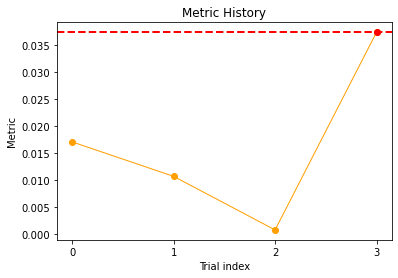

sklearn_model hparameters: {'algorithm': 'lbfgs', 'all_possible_states': True, 'all_possible_transitions': False, 'c1': 165.58222422754613, 'c2': 0.0016050698349389192, 'delta': 0.06677422781583814, 'epsilon': 0.002576279634223993, 'linesearch': 'StrongBacktracking', 'max_linesearch': 33, 'min_freq': 10, 'num_memories': 8, 'period': 12, 'model_class': <class 'sklearn_crfsuite.estimator.CRF'>}
 16%|█▌        | 4/25 [1:56:41<10:12:36, 1750.30s/trial, best loss: -0.03743480300806369]

In [13]:
delete_file('trials_sklearn')

model = sklearn_model.SklearnModel1(minimize_metric = False)

res = model.search(data, crf_params.search_space, crf_params.search_fixed, num_iter = 25)
best_hparams = res['best_params']
best_hparams.update(crf_params.search_fixed)

In [ ]:
model = sklearn_model.SklearnModel1(minimize_metric = False, **best_hparams)
res = model.fit(data)

res

In [ ]:
model.save()

In [14]:
def get_doc_text(doc_id):
    doc = load_train_example_by_name(doc_id)
    doc_tokens = preprocess_tokenize_doc(doc)
    return ' '.join(doc_tokens)# TODO: unlazy

In [28]:
test_preds = []
ids = []
for doc_id in val_idx[:5]:
    
    # Load and preprocess
    doc = load_train_example_by_name(doc_id)
    doc_tokens = preprocess_tokenize_doc(doc)

    # Extract features
    x = {'output': pd.DataFrame({'TOKEN': doc_tokens})}
    x = feature_extractor.transform(x)

    # Predict
    pred = model.predict([x])
    pred = pred[0]['output'][0]
    pred = np.array([int(p) for p in pred])

    # Token idx
    pos_pred_idx = [i[0] for i in np.argwhere(pred == 1)]
    pred_delimited = []
    if len(pred > 0):
        pred_prev = pos_pred_idx[0]
        for p in pos_pred_idx:
            if p - pred_prev > 3:
                pred_delimited.append(-1)
            
            pred_delimited.append(p)
            pred_prev = p

    # Get corresponding tokens
    pred_tokens = [('|' if i == -1 else doc_tokens[i]) for i in pred_delimited]
    
    pred_joined = ' '.join(pred_tokens)
    pred_tokens = pred_joined.split(' | ')
    preds_joined = list(set(pred_tokens))

    preds_joined_cleaned = preds_joined#[]

    """for p in preds_joined:
        label_similarities = [fuzz.ratio(l, p) for l in labels]
        if max(label_similarities) >= 70:
            preds_joined_cleaned.append(labels[np.argmax(label_similarities)])"""
        
    # 2 options: remove if not similar to any label, or keep without modification

    preds_joined_cleaned = list(set(preds_joined_cleaned))
    test_preds.append('|'.join(preds_joined_cleaned))
    ids.append(doc_id)

sub_df = pd.DataFrame(columns = ['Id', 'PredictionString'])
sub_df['Id'] = ids
sub_df['PredictionString'] = test_preds

In [29]:
pd.options.display.max_rows = 25
pd.options.display.max_colwidth = 150
sub_df

,Id,PredictionString
0,7a9fcb80-85b1-47bb-a3a5-4069c69b4068,adni
1,d6bce360-e056-42ba-9b18-e687407f1661,early childhood longitudinal study
2,09f36a02-f4d1-4fb3-840c-5c7a2285b17c,baltimore longitudinal study of aging
3,9e08d7d3-8f8c-4b0a-9445-f9cfba0813b7,agricultural resource management survey
4,e657b6c3-e32c-4daf-a092-3de500980f37,adni
